# Reading Data

In [88]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sktime.forecasting.all import temporal_train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import sktime
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from functools import partial
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb
from sklearn.metrics import make_scorer

In [31]:
data_gbp = pd.read_csv('GBP.csv',index_col=0)
data_cad = pd.read_csv('CAD.csv',index_col=0)
data_eur = pd.read_csv('EUR.csv',index_col=0)
data_nzd = pd.read_csv('NZD.csv',index_col=0)
data_jpy = pd.read_csv('JPY.csv',index_col=0)
data_gbp.index = pd.to_datetime(data_gbp.index)
data_cad.index = pd.to_datetime(data_cad.index)
data_eur.index= pd.to_datetime(data_eur.index)
data_nzd.index = pd.to_datetime(data_nzd.index)
data_jpy.index= pd.to_datetime(data_jpy.index)

In [19]:
X_gbp, y_gbp = data_gbp[['YC/GBR5Y - Yield', 'YC/USA5Y - Rate']], data_gbp['Direction']
train_test_size=0.7

In [20]:
X_train, X_test = X_gbp.iloc[:int(train_test_size*len(X_gbp))], X_gbp.iloc[int(train_test_size*len(X_gbp)):]
y_train, y_test = y_gbp.iloc[:int(train_test_size*len(X_gbp))], y_gbp.iloc[int(train_test_size*len(X_gbp)):]

# Grid Search

In [21]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)

In [22]:
param_grid = {'learning_rate': np.arange(.1,1.6,.1),
              'gamma': np.arange(0,5,.25),
              'max_depth': np.arange(4,10,1)
             }

In [23]:
random_search = RandomizedSearchCV(xgb.XGBClassifier(), 
                                   param_distributions=param_grid, 
                                   cv = 5, 
                                   scoring='neg_root_mean_squared_error', 
                                   n_jobs=-1, 
                                   verbose=3, 
                                   random_state=1001 )

In [24]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=-1,
                   param_d

In [25]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=4.25, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [26]:
top_xgboost_model = random_search.best_estimator_
# Run train and test predictions
ypred_train = top_xgboost_model.predict(X_train)
ypred_test = top_xgboost_model.predict(X_test)

In [27]:
print('mse train: {}'.format( round(accuracy_score(y_train, ypred_train),3)))
print('mse test:  {}'.format( round(accuracy_score(y_test, ypred_test),3)))

mse train: 0.568
mse test:  0.49


# Rolling XGBoost

In [28]:
time_frames = list(zip(np.arange(2004,2019,3), np.arange(2007,2021,3)))
accuracy_list = list()

for i in time_frames:
    data_rolling = data_gbp.loc[str(i[0]):str(i[1])]
    X, y = data_rolling[['YC/GBR5Y - Yield', 'YC/USA5Y - Rate']], data_rolling['Direction']
    X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)
    
    base = xgb.XGBClassifier()
    base_result = base.fit(X_train, y_train.values.ravel())
    ypred_train = base_result.predict(X_train)
    ypred_test = base_result.predict(X_test)
    
    classifier = xgb.XGBClassifier()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, y_pred))

print(accuracy_list)

[0.45662100456621, 0.5095785440613027, 0.46360153256704983, 0.5172413793103449, 0.5230769230769231]


# Hyperopt Tuning with Regressor

In [66]:
data_gbp

,GBPUSD,YC/GBR5Y - Yield,YC/USA5Y - Rate,Change in Spot,Direction
Date,,,,,
2004-08-23,0.55120,4.9500,3.42,0.00210,1
2004-08-24,0.55760,5.0300,3.46,0.00640,1
2004-08-25,0.55660,5.0300,3.46,-0.00100,0
2004-08-26,0.55740,4.9800,3.46,0.00080,1
2004-08-27,0.55800,4.9600,3.42,0.00060,1
...,...,...,...,...,...
2019-12-25,0.77035,0.5506,1.72,-0.00155,0
2019-12-26,0.76880,0.5510,1.72,-0.00155,0
2019-12-27,0.76390,0.5514,1.72,-0.00490,0


In [67]:
X_gbp, y_gbp = data_gbp[['YC/GBR5Y - Yield','YC/USA5Y - Rate']],data_gbp['GBPUSD']

In [68]:
X_train, X_test = X_gbp.iloc[:int(train_test_size*len(X_gbp))], X_gbp.iloc[int(train_test_size*len(X_gbp)):]
y_train, y_test = y_gbp.iloc[:int(train_test_size*len(X_gbp))], y_gbp.iloc[int(train_test_size*len(X_gbp)):]

In [77]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb

from sklearn.metrics import make_scorer

# MAPE computation
def mape(y, yhat, perc=True):
    n = len(yhat.index) if type(yhat) == pd.Series else len(yhat)    
    mape = []
    for a, f in zip(y, yhat):
        # avoid division by 0
        if f > 1e-9:
            mape.append(np.abs((a - f)/a))
    mape = np.mean(np.array(mape))
    return mape * 100. if perc else mape


def train_xgb(params, X_train, y_train):
    """
    Train XGBoost regressor using the parameters given as input. The model
    is validated using standard cross validation technique adapted for time series
    data. This function returns a friendly output for the hyper parameter optimization
    module.
    
    Parameters
    ----------
    params: dict with the parameters of the XGBoost regressor. For complete list see: 
            https://xgboost.readthedocs.io/en/latest/parameter.html
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets    
    
    Returns
    -------
    dict with keys 'model' for the trained model, 'status' containing the hyperopt
    status string and 'loss' with the RMSE obtained from cross-validation
    """
    
    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])

    try:
        model = xgb.XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"])

        result = model.fit(X_train, 
                           y_train.values.ravel(),
                           eval_set=[(X_train, y_train.values.ravel())],
                           early_stopping_rounds=50,
                           verbose=False)
        
        # cross validate using the right iterator for time series
        cv_space = TimeSeriesSplit(n_splits=5)
        cv_score = cross_val_score(model, 
                                   X_train, y_train.values.ravel(), 
                                   cv=cv_space, 
                                   scoring=mape_scorer)

        rmse = np.abs(np.mean(np.array(cv_score)))
        return {
            "loss": rmse,
            "status": STATUS_OK,
            "model": model
        }
        
    except ValueError as ex:
        return {
            "error": ex,
            "status": STATUS_FAIL
        }
    
def optimize_xgb(X_train, y_train, max_evals=10):
    """
    Run Bayesan optimization to find the optimal XGBoost algorithm
    hyperparameters.
    
    Parameters
    ----------
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets
    max_evals: the maximum number of iterations in the Bayesian optimization method
    
    Returns
    -------
    best: dict with the best parameters obtained
    trials: a list of hyperopt Trials objects with the history of the optimization
    """
    
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 4, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1)
    }

    objective_fn = partial(train_xgb, 
                           X_train=X_train, 
                           y_train=y_train)
    
    trials = Trials()
    best = fmin(fn=objective_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # evaluate the best model on the test set
    print(f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """)
    return best, trials

In [78]:
mape_scorer = make_scorer(mape, greater_is_better=False)
best, trials = optimize_xgb(X_train, y_train, max_evals=50)

100%|██████████| 50/50 [01:48<00:00,  2.16s/trial, best loss: 6.655252053965787]

    Best parameters:
        learning_rate: 0.011348868987810769 
        n_estimators: 180.0
        max_depth: 7.0
        sub_sample: 0.90578083815
        gamma: 53.0
    


In [79]:
best

{'gamma': 53.0,
 'learning_rate': 0.011348868987810769,
 'max_depth': 7.0,
 'n_estimators': 180.0,
 'subsample': 0.90578083815}

In [80]:
model = xgb.XGBRegressor(n_estimators=int(best['n_estimators']), 
                                 max_depth=int(best['max_depth']), 
                                 learning_rate=best["learning_rate"],
                                 subsample=best["subsample"])

result = model.fit(X_train, 
                   y_train.values.ravel(),
                   eval_set=[(X_train, y_train.values.ravel())],
                   early_stopping_rounds=50,
                   verbose=False)

In [81]:
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)

<AxesSubplot:xlabel='Date'>

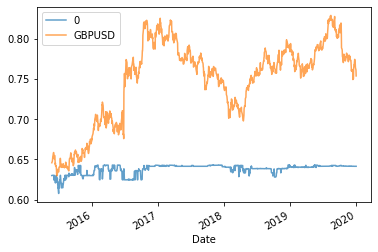

In [82]:
pd.concat(
    [
        pd.Series(ypred_test, index=y_test.index),
        y_test,
    ], axis=1
).plot(alpha=0.7)

In [89]:
MAPE_func = sktime.performance_metrics.forecasting.MeanAbsolutePercentageError(symmetric=False)

In [90]:
print('mse train: {}'.format( round(MAPE_func(y_train, ypred_train),3)))
print('mse test:  {}'.format( round(MAPE_func(y_test, ypred_test),3)))

mse train: 0.024
mse test:  0.143
